**Summary**

In this notebook we explain how to load `passim`'s output into a `pandas`' `DataFrame`, a data structure that comes in very handy when analyzing and/or plotting data.

Please note that if the **size of your data** changes considerably (i.e. the number of detected text reuse clusters shifts from thousands to millions) we recommened the use of [`dask` DataFrames](https://docs.dask.org/en/latest/dataframe.html) as it is able e.g. to distribute computation and memory usage over a cluster made of several machines. 

(This file is from the Programming Historian tutorial)


## Imports

In [1]:
import matplotlib
import os
import pandas as pd

In [2]:
# this prints the current pandas' version
pd.__version__

'1.3.0'

## Configuration

**NB**: In case you speficied a different output folder when running `passim`, you'll need to change the variables here below.

In [3]:
passim_output_path = os.path.join('../', 'data', 'passim_output_bible_min3','out.json')

## Utility functions

Some very general functions that should be usable with any `passim` JSON output.

In [4]:
def read_passim_json(output_dir: str) -> pd.DataFrame:
    """
    A simple function that reads passim's JSON output
    into a pandas DataFrame.
    """

    # detect all JSON files filtering on file extension
    files = [
        os.path.join(output_dir, f)
        for f in os.listdir(output_dir)
        if f.endswith('.json')
    ]
    
    print(f'{len(files)} files detected in folder {output_dir}')
    
    # read each JSON file into a temporary pandas dataframe
    # thus creating a list of dataframes
    dfs = [
        pd.read_json(file, lines=True)
        for file in files
    ]
    
    # concatenate all temporary dataframes into a single one
    # and set the column `uid` as the dataframe index
    df = pd.concat(dfs).set_index('uid')
    
    n_clusters = df.cluster.nunique()
    n_passages = df.shape[0]
    print(f'Passim data contain {n_passages} text reuse passages, grouped into {n_clusters} clusters')
    return df

def passages2clusters(passages_df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that aggregates passim's output at the cluster-level.
    """
    impresso_tr_clusters = passages_df.groupby('cluster').agg({'size': 'count'})
    impresso_tr_clusters.rename(columns={'size': 'cluster_size'}, inplace=True)
    return impresso_tr_clusters
    

## Read in `passim`'s output for *impresso*

First thing first, we need to read in `passim`'s JSON output; each JSON document represents a *text reuse passage* (not a cluster!) and the data is split over several smallish JSON files contained in `passim`'s output directory.

In [5]:
tr_passages = read_passim_json(passim_output_path)

6 files detected in folder ../data/passim_output_bible_min3/out.json
Passim data contain 25 text reuse passages, grouped into 10 clusters


In [6]:
# this gives the number of TR passages detected by passim
# on the sample impresso data
tr_passages.shape[0]

25

## Reshaping data: from passages to clusters

Since `passim`'s JSON represents text reuse passages, in order to do some analysis on text reuse clusters we need to **reshape** our data. This is done by calling the `passages2clusters` function which will transform a DataFrame of passages into a DataFrame of clusters. 

Here, for the sake of semplicity, each cluster has two bits of information (columns): 
1. a cluster ID (the one assigned by `passim`)
2. its size, namely the number of similar/repeated passages that a cluster contains. 

But for a more in-depth analysis, you may want to characterise each cluster by some more information, e.g. the timespan covered by passages in the cluster (if applicable).

In [7]:
tr_clusters = passages2clusters(tr_passages)

In [8]:
# the number of records (rows) in this dataframe
# correspondes to the number of clusters detected by passim
tr_clusters.shape[0]

10

## Plotting the distribution of cluster sizes (impresso)

An interesting thing for the analysis of TR is to get a sense of **how big are the clusters** we are dealing with. Similarly, we'd like to understand whether we have a lot of small or big clusters, and how much variance there is in their sizes.

This information is contained in the column `cluster_size` of our cluster `DataFrame`.

What's the smallest cluster?

In [9]:
tr_clusters.cluster_size.min()

2

And the biggest one?

In [10]:
tr_clusters.cluster_size.max()

3

Now, we can start looking at the frequency distribution of cluster sizes. The `pandas.Series`' method `value_counts()` returns the frequency of each size -- which is exactly what we need here.

In [11]:
tr_clusters.cluster_size.value_counts()

2    5
3    5
Name: cluster_size, dtype: int64

We can get some more statistical information about the distribution of size by calling the `describe()` method. Tis will return the min/max/mean value, standard deviation, and the three quartiles.

In [12]:
tr_clusters.cluster_size.describe()

count    10.000000
mean      2.500000
std       0.527046
min       2.000000
25%       2.000000
50%       2.500000
75%       3.000000
max       3.000000
Name: cluster_size, dtype: float64

The majority of our clusters are very small; 90% of them, in fact, contains at maximum 4 passages.

In [13]:
tr_clusters.quantile(.9)

cluster_size    3.0
Name: 0.9, dtype: float64

This distribution can also be plotted by using a bar plot:

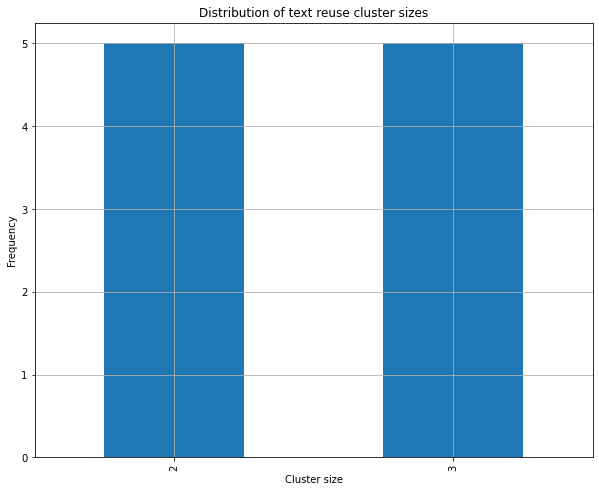

In [14]:
%matplotlib inline
ax = tr_clusters.cluster_size.value_counts().plot(
    kind='bar',
    log=False,
    grid=True,
    figsize=(10, 8),
    xlabel='Cluster size',
    ylabel='Frequency',
    title='Distribution of text reuse cluster sizes'
)

Since our distribution is very skewed (a lot of clusters with size 2, and much less of them for other sizes), some data points become invisible unless with use a logarithmic scale for the Y axis:

---

Starting now:


In [15]:
tr_clusters

,cluster_size
cluster,
8589934592,2
8589934593,3
8589934594,2
8589934595,3
8589934596,3
8589934597,3
8589934598,3
17179869185,2
17179869187,2


In [16]:
tr_passages.sort_values(by=['cluster'])

,cluster,size,bw,ew,id,series,text,gid,begin,end
uid,,,,,,,,,,
2865213028299747379,8589934592,2,660,755,ST18740813-V01-06-p1.txt-ground_truth,not_bible,Remember the Sabbath day to keep it holy. Six ...,-7044454596298023190,3562,4031
-3804236650871972787,8589934592,2,57343,57443,king_james,bible,"Remember the sabbath day, to keep it holy.\n\n...",-6359048191199748886,286783,287288
5497860786606132514,8589934593,3,695,876,ST18740813-V01-06-p1.txt-auto_corrected,not_bible,form unto two of them as they walked Remember ...,-7044454596298023190,3695,4609
-3804236650871972787,8589934593,3,697896,697964,king_james,bible,"he appeared in another form unto two of them, ...",-6359048191199748886,3547514,3547881
2865213028299747379,8589934593,3,2153,2217,ST18740813-V01-06-p1.txt-ground_truth,not_bible,He appeared in another form unto two of them a...,-7044454596298023190,11361,11708
-3804236650871972787,8589934594,2,493369,493419,king_james,bible,The earth also is defiled under the inhabitant...,-6359048191199748886,2506203,2506520
2865213028299747379,8589934594,2,1998,2047,ST18740813-V01-06-p1.txt-ground_truth,not_bible,The earth also is defiled under the inhabitant...,-7044454596298023190,10494,10790
-3804236650871972787,8589934595,3,746107,746150,king_james,bible,"Then the same day at evening, being the first ...",-6359048191199748886,3788382,3788603
2865213028299747379,8589934595,3,2220,2263,ST18740813-V01-06-p1.txt-ground_truth,not_bible,Then the same day at evening being the first d...,-7044454596298023190,11725,11940


In [17]:
cluster_ids = list(tr_passages.cluster.unique())

In [18]:
for _id in cluster_ids:
    
    print("Cluster {}\n".format(_id))
    subset = tr_passages[tr_passages['cluster'] == _id]
    subset_dict = subset[['id', 'text']].to_dict('records')
    
    for each in subset_dict:
        print("ID: {}\n\nText: {}\n\n".format(each['id'], each['text']))


Cluster 8589934598

ID: YI18540801-V02-08-p4.txt-ground_truth

Text: Lord my heart is not haughty nor mine eyes lofty neither do I exercise myself in great matters or in things too high for me. 


ID: king_james

Text: Lord, my heart is not haughty, nor mine eyes lofty: neither do I
exercise myself in great matters, or in things too high for me.




ID: YI18540801-V02-08-p4.txt-auto_corrected

Text: Lord my haart is not haughty nor mine eyes lofty neither do I exercise myself in great matters or in things too high for me. 


Cluster 8589934592

ID: ST18740813-V01-06-p1.txt-ground_truth

Text: Remember the Sabbath day to keep it holy. Six days shalt thou labor and do all thy work but the seventh day is the Sabbath of the Lord thy God in it thou shalt not do any work thou nor thy son nor thy daughter thy man servant nor thy maidservant nor thy cattle nor thy stranger that is within thy gates for in six days the Lord made heaven and earth the sea and all that in them is and rested the sev